# Understanding Removed Statements Dataset

Source of data: [GDrive | Removed Stataments of Wikidata | Feb 1 2021](https://drive.google.com/file/d/1TQP1rADdvhDjsvBpLzSE9Bx3n73wf-Md/view?usp=sharing)

Steps performed:
* Divide dataset into 2 halves - redirected and non-redirected. Redirected dataset has either node1 or node2 as redirected. But non-redirected has both node1, node2 not redirected


**Summary**

Removed Statements dataset has 76.5M removed statements. Out of these, 

## Redirects determination and division of dataset into 2 halves

* Since, redirects dataset was not present, a SPARQL query was run to determine all the redirects existing at the moment. This was done on Feb 19, 2021. This was executed using [SPARQL query](https://query.wikidata.org/). Query run was:
    ```
    SELECT ?old_node
    WHERE {
      ?old_node owl:sameAs ?new_node.
    }
    ```
* This has few lexemes as well which we don't need. So, I then ran the query:
    ```
    SELECT ?old_node
    WHERE {
      ?old_node owl:sameAs ?new_node.
      ?new_node rdf:type ontolex:LexicalEntry.
    }
    ```
* After removing the lexemes from the nodes file, a final redirected non-lexemes file was created with data from Feb 19, 2021: `data/SPARQL_redirects_non-lexemes.tsv`.
* Using this reduced dataset, I was able to determine in the removed_statements.tsv dataset, which nodes have been redirected - `../opAnalysis/removed_statements_redirects_basis_node1or2.tsv`. This has removed statements in which either node1 or node2 is redirected.
* After this, I am extracting the removed statements not present in this subset meaning it would correspond to all removed statements in neither node1 nor node2 is redirected - `../opAnalysis/removed_statements_both_nonredirects.tsv`

For this, I am using the following set of commands

In [2]:
import pandas as pd
import seaborn as sns

In [ ]:
# On the basis of SPARQL
!kgtk ifexists -i ../../data/removed_statements.tsv\
    --filter-on ../../data/SPARQL_redirects_non-lexemes.tsv \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys id \
    -o ../../opAnalysis/removed_statements_redirects_basis_node1.tsv
!kgtk ifnotexists -i ../../data/removed_statements.tsv\
    --filter-on ../../data/SPARQL_redirects_non-lexemes.tsv \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys id \
    -o ../../opAnalysis/removed_statements_nonredirects_basis_node1.tsv
!kgtk ifexists -i ../../data/removed_statements.tsv\
    --filter-on ../../data/SPARQL_redirects_non-lexemes.tsv \
    --filter-mode NONE \
    --input-keys node2 \
    --filter-keys id \
    -o ../../opAnalysis/removed_statements_redirects_basis_node2.tsv
!kgtk ifnotexists -i ../../data/removed_statements.tsv\
    --filter-on ../../data/SPARQL_redirects_non-lexemes.tsv \
    --filter-mode NONE \
    --input-keys node2 \
    --filter-keys id \
    -o ../../opAnalysis/removed_statements_nonredirects_basis_node2.tsv
!kgtk ifnotexists -i ../../opAnalysis/removed_statements_redirects_basis_node1.tsv \
    --filter-on ../../opAnalysis/removed_statements_redirects_basis_node2.tsv \
    -o ../../opAnalysis/temp1.tsv
!kgtk cat -i ../../opAnalysis/temp1.tsv \
    ../../opAnalysis/removed_statements_redirects_basis_node2.tsv \
    -o ../../opAnalysis/removed_statements_redirects_basis_node1or2.tsv
!kgtk ifnotexists -i ../../data/removed_statements.tsv\
    --filter-on ../../opAnalysis/removed_statements_redirects_basis_node1or2.tsv \
    -o ../../opAnalysis/removed_statements_both_nonredirects.tsv

## P31 edges distribution

Now, we'll determine in this redirected dataset - `../../opAnalysis/removed_statements_redirects_basis_node1or2.tsv`, how many of these are P31 edges and determine more stats on these

### For Redirected Removed Statements

In [ ]:
!kgtk --debug query -i ../../opAnalysis/removed_statements_redirects_basis_node1or2.tsv \
    --match 'o: (a)-[:P31]->(b)' \
    --return 'b, count(distinct a)' \
    -o ../../opAnalysis/removed_statements_redirects_P31_stats1.tsv

In [7]:
df1 = pd.read_csv('../../opAnalysis/removed_statements_redirects_P31_stats1.tsv',sep='\t')
df1.columns = ['parent','count']
df1 = df1.sort_values(by=['count'],ascending=False)
df1 = df1.set_index('parent')
tot = df1['count'].sum()
df1['perc'] = df1['count'] / tot
df1.head(15)

count      perc
parent                     
Q4167836   526207  0.213808
Q17329259  301359  0.122448
Q5         222809  0.090531
Q4167410   108583  0.044119
Q13442814  101156  0.041102
Q7187       88231  0.035850
Q11266439   61007  0.024788
Q4423781    53671  0.021808
Q17143521   51581  0.020958
Q15917122   50642  0.020577
Q486972     49257  0.020014
Q16521      46522  0.018903
Q318        26722  0.010858
Q532        23721  0.009638
Q20900710   23482  0.009541

Find unique list of redirected nodes

In [9]:
!kgtk unique -i ../../opAnalysis/removed_statements_redirects_basis_node1.tsv --column node1 -o ../../opAnalysis/removed_statements_redirects_basis_node1_nodes_only.tsv

In [20]:
!kgtk unique -i ../../opAnalysis/removed_statements_redirects_basis_node2.tsv --column node2 -o ../../opAnalysis/removed_statements_redirects_basis_node2_nodes_only.tsv

In [21]:
!kgtk cat -i ../../opAnalysis/removed_statements_redirects_basis_node1_nodes_only.tsv \
    ../../opAnalysis/removed_statements_redirects_basis_node2_nodes_only.tsv \
    -o ../../opAnalysis/removed_statements_redirects_nodes_only.tsv

In [22]:
!kgtk query -i ../../opAnalysis/removed_statements_redirects_nodes_only.tsv \
    --match '(node1)-[label]->(node2)' \
    --return 'node1, label.label, sum(node2)' \
    -o ../../opAnalysis/removed_statements_redirects_nodes_only_unique.tsv

In [23]:
!wc -l ../../opAnalysis/removed_statements_redirects_nodes_only_unique.tsv

1864249 ../../opAnalysis/removed_statements_redirects_nodes_only_unique.tsv


### For non-redirected removed statements

In [ ]:
!kgtk --debug query -i ../../opAnalysis/removed_statements_both_nonredirects.tsv \
    --match 'o: (a)-[:P31]->(b)' \
    --return 'b, count(distinct a)' \
    -o ../../opAnalysis/removed_statements_nonredirects_P31_stats1.tsv

In [9]:
df1 = pd.read_csv('../../opAnalysis/removed_statements_nonredirects_P31_stats1.tsv',sep='\t')
df1.columns = ['parent','count']
df1 = df1.sort_values(by=['count'],ascending=False)
df1 = df1.set_index('parent')
tot = df1['count'].sum()
df1['perc'] = df1['count'] / tot
df1.head(15)

count      perc
parent                     
Q4167836   368888  0.102453
Q4167410   132403  0.036773
Q5         130252  0.036176
Q571       126883  0.035240
Q11266439  125824  0.034946
Q838948    119928  0.033308
Q486972    108105  0.030025
Q532       106786  0.029658
Q783794    101121  0.028085
Q1539532    78186  0.021715
Q916333     62789  0.017439
Q16521      53402  0.014832
Q7366       45005  0.012499
Q13406463   42582  0.011827
Q18593264   40505  0.011250

## Properties Distribution

### For redirected removed statements

In [ ]:
!kgtk --debug query -i ../../opAnalysis/removed_statements_redirects_basis_node1or2.tsv \
    --match 'o: (a)-[r]->(b)' \
    --return 'r.label, count(distinct a)' \
    -o ../../opAnalysis/removed_statements_redirects_props_dist.tsv

In [6]:
df1 = pd.read_csv('../../opAnalysis/removed_statements_redirects_props_dist.tsv',sep='\t')
df1.columns = ['parent','count']
df1 = df1.sort_values(by=['count'],ascending=False)
df1 = df1.set_index('parent')
tot = df1['count'].sum()
df1['perc'] = df1['count'] / tot
df1.head(15)

count      perc
parent                   
P31     2381072  0.234921
P17      357286  0.035251
P1433    299464  0.029546
P735     295778  0.029182
P50      268412  0.026482
P2860    243607  0.024035
P625     227779  0.022473
P106     185184  0.018271
P131     183759  0.018130
P21      179069  0.017667
P921     167723  0.016548
P279     162394  0.016022
P1566    160213  0.015807
P684     152695  0.015065
P703     119182  0.011759

### For non-redirected removed statements

In [ ]:
!kgtk --debug query -i ../../opAnalysis/removed_statements_both_nonredirects.tsv \
    --match 'o: (a)-[r]->(b)' \
    --return 'r.label, count(distinct a)' \
    -o ../../opAnalysis/removed_statements_nonredirects_props_dist.tsv

In [11]:
df1 = pd.read_csv('../../opAnalysis/removed_statements_nonredirects_props_dist.tsv',sep='\t')
df1.columns = ['parent','count']
df1 = df1.sort_values(by=['count'],ascending=False)
df1 = df1.set_index('parent')
tot = df1['count'].sum()
df1['perc'] = df1['count'] / tot
df1.head(15)

count      perc
parent                   
P2093   6173393  0.161314
P1476   4238487  0.110754
P31     3327644  0.086953
P569    2011539  0.052563
P625    1494410  0.039050
P577    1116328  0.029170
P234     999522  0.026118
P570     983201  0.025692
P131     927413  0.024234
P364     870224  0.022739
P2044    780870  0.020405
P279     765112  0.019993
P969     732461  0.019140
P356     413439  0.010803
P637     387091  0.010115

# Comparison Removed NR dataset with Qnodes, literals

First, let's split this dataset

In [ ]:
!kgtk --debug query -i ../../opAnalysis/removed_statements_both_nonredirects.tsv \
    ../../gdrive-kgtk-dump-2020-12-07/metadata.property.datatypes.tsv.gz \
    --match "non: (x)-[r{label: property}]->(y), datatypes: (property)-[]->(:wikibase\-item)" \
    -o ../../opAnalysis/removed_statements_both_nonredirects_newSeg_qnode.tsv

In [ ]:
!kgtk --debug query -i ../../opAnalysis/removed_statements_both_nonredirects.tsv \
    ../../gdrive-kgtk-dump-2020-12-07/metadata.property.datatypes.tsv.gz \
    --match "non: (x)-[r{label: property}]->(y), datatypes: (property)-[]->(:quantity)" \
    -o ../../opAnalysis/removed_statements_both_nonredirects_newSeg_qty.tsv
!kgtk --debug query -i ../../opAnalysis/removed_statements_both_nonredirects.tsv \
    ../../gdrive-kgtk-dump-2020-12-07/metadata.property.datatypes.tsv.gz \
    --match "non: (x)-[r{label: property}]->(y), datatypes: (property)-[]->(:string)" \
    -o ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str.tsv
!kgtk --debug query -i ../../opAnalysis/removed_statements_both_nonredirects.tsv \
    ../../gdrive-kgtk-dump-2020-12-07/metadata.property.datatypes.tsv.gz \
    --match "non: (x)-[r{label: property}]->(y), datatypes: (property)-[]->(:`wikibase-item`)" \
    -o ../../opAnalysis/removed_statements_both_nonredirects_newSeg_qnode.tsv
!kgtk --debug query -i ../../opAnalysis/removed_statements_both_nonredirects.tsv \
    ../../gdrive-kgtk-dump-2020-12-07/metadata.property.datatypes.tsv.gz \
    --match "non: (x)-[r{label: property}]->(y), datatypes: (property)-[]->(:time)" \
    -o ../../opAnalysis/removed_statements_both_nonredirects_newSeg_date.tsv


### String Comparison

In [3]:
!kgtk query -i ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str.tsv     \
    ../../gdrive-kgtk-dump-2020-12-07/claims.string.tsv.gz     \
    --match "r: (x)-[r]->(y), c: (x)-[s]->(z)"     \
    --where "r.label = s.label"     \
    --return 'x as `node1`, r.label as `label`, y as `node2`, s.label as `node2;newLabl`, z as `node2;nw`'     \
    -o ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals.tsv \
    --graph-cache ~/temp2.sqlite3.db

^C


In [ ]:
# !sed -i '1s/.*/node1\tlabel\tnode2\tnode2;newLabl\tnode2;nw/' removed_statements_both_nonredirects_newSeg_str_new_vals.tsv

The strings subset has a branching factor of approx 10. i.e. 1 removed statement with string literal has been replaced by around 10 new statements (with same node1-label combination). Doing the same comparisons won't give us much insights. Instead, let's truncate this dataset while retaining just the counts of branching factor from each of these node1-label combinations. 

In [ ]:
!kgtk --debug query -i ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals.tsv \
    --match "(node1)-[r]->(node2{newLabl: newLabel, nw: newValue})" \
    --return 'node1, r.label, node2, newLabel as `node2;newLabel`, max(newValue) as `node2;newValue`, count(newValue) as `node2;branching`' \
    -o ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals_truncated.tsv \
    --graph-cache ~/sqlite3_caches/temptrunc.sqlite3.db

[2021-04-12 08:48:21 sqlstore]: IMPORT graph directly into table graph_1 from /data/wd-correctness/opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals.tsv ...
[2021-04-12 09:25:32 query]: SQL Translation:
---------------------------------------------
  SELECT graph_1_c1."node1", graph_1_c1."label", graph_1_c1."node2", graph_1_c1."node2;newLabl" "_aLias.node2;newLabel", max(graph_1_c1."node2;nw") "_aLias.node2;newValue", count(graph_1_c1."node2;nw") "_aLias.node2;branching"
     FROM graph_1 AS graph_1_c1
     WHERE graph_1_c1."node2;newLabl"=graph_1_c1."node2;newLabl"
     AND graph_1_c1."node2;nw"=graph_1_c1."node2;nw"
     GROUP BY graph_1_c1."node1", graph_1_c1."label", graph_1_c1."node2", "_aLias.node2;newLabel"
  PARAS: []
---------------------------------------------


On this truncated dataset, we will next compute the stats and comparisons. Note: Our original string literals subset of removed statements was around 9 GB. With the join operation with claims, this had increased to 90 GB. We have now truncated this dataset to 778 MB

In [8]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals_truncated.tsv

14349490 ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals_truncated.tsv


In [ ]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals_measured.tsv

In [12]:
!head ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals_truncated.tsv

node1	label	node2	node2;newLabel	node2;newValue	node2;branching
P1003	P1630	http://alephnew.bibnat.ro:8991/F?func=find-b&request=$1&find_code=SYS&adjacent=Y&local_base=NLR10	P1630	"http://aleph.bibnat.ro:8991/F/?func=direct&local_base=NLR10&doc_number=$1"	1
P1004	P1921	http://musicbrainz.org/$1/place	P1921	"http://musicbrainz.org/place/$1"	1
P1004	P1921	https://musicbrainz.org/place/$1	P1921	"http://musicbrainz.org/place/$1"	1
P1005	P1630	http://purl.pt/index/geral/aut/PT/$1.html	P1630	"http://urn.bn.pt/nca/unimarc-authorities/html?id=$1"	3
P1005	P1630	http://urn.bn.pt/nca/unimarc-authorities/txt?id=$1	P1630	"http://urn.bn.pt/nca/unimarc-authorities/html?id=$1"	3
P1006	P1630	http://data.bibliotheken.nl/id/thes/p$1	P1630	"https://opc-kb.oclc.org/PPN?PPN=$1"	3
P1006	P1630	http://opc4.kb.nl/DB=1/XMLPRS=Y/PPN?PPN=$1	P1630	"https://opc-kb.oclc.org/PPN?PPN=$1"	3
P1006	P1630	http://opc4.kb.nl/PPN?PPN=$1	P1630	"https://opc-kb.oclc.org/PPN?PPN=$1"	3
P1006	P1630	https://data.bibliotheken.nl/doc/

In [12]:
from dateutil.parser import parse
import re
import rltk
from rltk.similarity import levenshtein_distance as ld
from nltk.tokenize import word_tokenize as wt
from tqdm.notebook import tqdm

f1 = open("../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals_truncated.tsv","r")
fStr = open("../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals_measured2.tsv","w")

firstLine = next(f1).rstrip()

fStr.write(firstLine+"\tVersionBool\tRangeBool\tLevDist\tRearranged\tRearrangedFirstNP\n")

for line in tqdm(f1):
    line = line.rstrip()
    val1 = line.split("\t")[2]
    val2 = line.split("\t")[4]
    val2 = val2[1:-1]
    versionBool = bool(re.fullmatch("[\d\.]+[\w\s\d]*",val1))
    rangeBool = bool(re.fullmatch("[\d]+[-|–][\d]+",val1))
    LevDist = ld(val1,val2)
    rearranged = set(wt(val1)) == set(wt(val2))
    rearrangedFirstNP = set(wt(val1)) == set(wt(val2[1:]))
    fStr.write(line+ "\t" + str(versionBool) + "\t" + str(rangeBool) + "\t" + \
               str(LevDist) + "\t" + str(rearranged) + "\t" + str(rearrangedFirstNP) + "\n")

fStr.close()

0it [00:00, ?it/s]

In [ ]:
!kgtk ifnotexists -i ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals.tsv \
    --filter-on ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals_measured2.tsv \
    --filter-mode NONE \
    --input-keys label node1 \
    --filter-keys label node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_unmatched2.tsv

In [13]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals.tsv

1927007651 ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals.tsv


In [14]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals_measured2.tsv

14349490 ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals_measured2.tsv


In [4]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_unmatched.tsv

1 ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_unmatched.tsv


In [15]:
!head ../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals_measured.tsv

node1	label	node2	node2;newLabel	node2;newValue	node2;branching	VersionBool	RangeBool	LevDist	Rearranged	RearrangedFirstNP
P1003	P1630	http://alephnew.bibnat.ro:8991/F?func=find-b&request=$1&find_code=SYS&adjacent=Y&local_base=NLR10	P1630	"http://aleph.bibnat.ro:8991/F/?func=direct&local_base=NLR10&doc_number=$1"	1
	False	False	51	False	False
P1004	P1921	http://musicbrainz.org/$1/place	P1921	"http://musicbrainz.org/place/$1"	1
	False	False	6	False	False
P1004	P1921	https://musicbrainz.org/place/$1	P1921	"http://musicbrainz.org/place/$1"	1
	False	False	1	False	False
P1005	P1630	http://purl.pt/index/geral/aut/PT/$1.html	P1630	"http://urn.bn.pt/nca/unimarc-authorities/html?id=$1"	3
	False	False	31	False	False
P1005	P1630	http://urn.bn.pt/nca/unimarc-authorities/txt?id=$1	P1630	"http://urn.bn.pt/nca/unimarc-authorities/html?id=$1"	3


In [1]:
import pandas as pd
str_df = pd.read_csv("../../opAnalysis/removed_statements_both_nonredirects_newSeg_str_new_vals_measured2.tsv",sep='\t')

In [2]:
str_df.head()

node1  label                                              node2  \
0  P1003  P1630  http://alephnew.bibnat.ro:8991/F?func=find-b&r...   
1  P1004  P1921                    http://musicbrainz.org/$1/place   
2  P1004  P1921                   https://musicbrainz.org/place/$1   
3  P1005  P1630          http://purl.pt/index/geral/aut/PT/$1.html   
4  P1005  P1630  http://urn.bn.pt/nca/unimarc-authorities/txt?i...   

  node2;newLabel                                     node2;newValue  \
0          P1630  http://aleph.bibnat.ro:8991/F/?func=direct&loc...   
1          P1921                    http://musicbrainz.org/place/$1   
2          P1921                    http://musicbrainz.org/place/$1   
3          P1630  http://urn.bn.pt/nca/unimarc-authorities/html?...   
4          P1630  http://urn.bn.pt/nca/unimarc-authorities/html?...   

   node2;branching  VersionBool  RangeBool  LevDist  Rearranged  \
0                1        False      False       51       False   
1                1        False      False        6       False   
2                1        False      False        1       False   
3                3        False      False       31       False   
4                3        False      False        3       False   

   RearrangedFirstNP  
0              False  
1              False  
2              False  
3              False  
4              False

In [32]:
len(str_df[str_df['LevDist'] == 0])

62146

In [5]:
import re
bool(re.fullmatch("[\d\.]+[\w\s\d]*","http://purl.pt/index/geral/aut/PT/$1.html"))

False

In [ ]:
str_df['node2;branching'].mean()

In [ ]:
str_df['node2;branching'].value_counts().sort_index()

In [3]:
str_df['node2;branching'].value_counts().sum()

14349489

In [4]:
print(f"Out of {len(str_df)} updates, {str_df['VersionBool'].sum()} correspond to changes due to version change with average branching factor: {str_df[str_df['VersionBool'] == True]['node2;branching'].mean()}")

Out of 14349489 updates, 254884 correspond to changes due to version change with average branching factor: 1.7222579683306916


In [5]:
str_df[str_df['VersionBool'] == True].LevDist.describe()

count    254884.000000
mean          3.783427
std           3.277387
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max         209.000000
Name: LevDist, dtype: float64

In [6]:
print(f"Out of {len(str_df)} updates, {str_df['RangeBool'].sum()} correspond to changes due to range change with average branching factor: {str_df[str_df['RangeBool'] == True]['node2;branching'].mean()}")

Out of 14349489 updates, 321953 correspond to changes due to range change with average branching factor: 1.0656493339089868


In [7]:
str_df[str_df['RangeBool'] == True].LevDist.describe()

count    321953.000000
mean          2.343702
std           2.188649
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          47.000000
Name: LevDist, dtype: float64

In [8]:
print(f"Out of {len(str_df)} updates, {str_df['Rearranged'].sum()} correspond to changes due to rearrangement with average branching factor: {str_df[str_df['Rearranged'] == True]['node2;branching'].mean()}")

Out of 14349489 updates, 234286 correspond to changes due to rearrangement with average branching factor: 3.4882536728613744


In [9]:
str_df[str_df['Rearranged'] == True].LevDist.describe()

count    234286.000000
mean          2.873257
std           2.006146
min           0.000000
25%           0.000000
50%           4.000000
75%           4.000000
max          56.000000
Name: LevDist, dtype: float64

In [10]:
str_df.LevDist.describe()

count    1.434949e+07
mean     1.153558e+01
std      5.467439e+00
min      0.000000e+00
25%      9.000000e+00
50%      1.200000e+01
75%      1.400000e+01
max      1.445000e+03
Name: LevDist, dtype: float64

Text(0.5, 1.0, 'count v/s Lev edit distances')

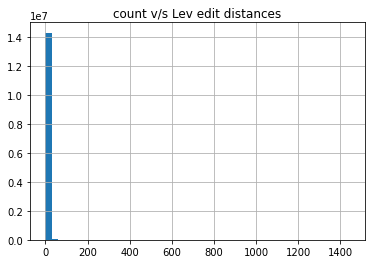

In [11]:
str_df.LevDist.hist(bins=50).set_title("count v/s Lev edit distances")

[Text(0.5, 0, 'Levenshtein Distance'), Text(0, 0.5, 'Count (in millions)')]

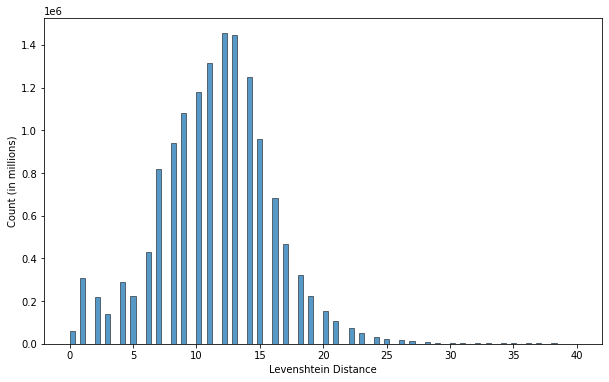

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=str_df[str_df.LevDist <= 40], x="LevDist", bins=100)
ax.set(xlabel="Levenshtein Distance", ylabel = "Count (in millions)")

In [13]:
# pd.qcut(str_df[str_df.LevDist <= 100]['LevDist'], q=100, retbins=True)

In [ ]:
str_df.LevDist[str_df.LevDist <= 20].hist(bins=100).set_title("count v/s Lev edit distances till 20")

In [ ]:
!kgtk ifnotexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_string.tsv     \
    --filter-on ../../opAnalysis/removed_statements_both_nonredirects_str_new_vals.tsv     \
    --filter-mode NONE \
    --input-keys node1 label \
    --filter-keys node1 label \
    -o ../../opAnalysis/removed_statements_both_nonredirects_str_not_updated.tsv

In [35]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_str_not_updated.tsv

16922584 ../../opAnalysis/removed_statements_both_nonredirects_str_not_updated.tsv


### Dates Comparison

In [63]:
!kgtk --debug query -i ../../opAnalysis/removed_statements_both_nonredirects_newSeg_date.tsv \
    ../../gdrive-kgtk-dump-2020-12-07/claims.time.tsv.gz \
    --match "newSeg: (x)-[r]->(y), time: (x)-[s]->(z)" \
    --where "r.label = s.label" \
    --return 'x, r.label, y, s.label as newNode2Label, z as newNode2' \
    -o ../../opAnalysis/removed_statements_both_nonredirects_newSeg_date_new_vals_rightone.tsv \
    --graph-cache ~/temp1.sqlite3.db


[2021-03-15 01:44:30 query]: SQL Translation:
---------------------------------------------
  SELECT graph_22_c1."node1", graph_22_c1."label", graph_22_c1."node2", graph_24_c2."label" "_aLias.newNode2Label", graph_24_c2."node2" "_aLias.newNode2"
     FROM graph_22 AS graph_22_c1, graph_24 AS graph_24_c2
     WHERE graph_22_c1."node1"=graph_24_c2."node1"
     AND (graph_22_c1."label" = graph_24_c2."label")
  PARAS: []
---------------------------------------------
[2021-03-15 01:44:30 sqlstore]: CREATE INDEX on table graph_22 column node1 ...
[2021-03-15 01:44:33 sqlstore]: ANALYZE INDEX on table graph_22 column node1 ...
[2021-03-15 01:44:34 sqlstore]: CREATE INDEX on table graph_24 column node1 ...
[2021-03-15 01:45:08 sqlstore]: ANALYZE INDEX on table graph_24 column node1 ...


In [ ]:
import pandas as pd
date_df = pd.read_csv("../../opAnalysis/removed_statements_both_nonredirects_newSeg_date_new_vals_rightone.tsv",sep='\t')

In [ ]:
# date_df1 = pd.read_csv("../../opAnalysis/removed_statements_both_nonredirects_new_vals_date.tsv",sep='\t')

In [ ]:
date_df.head()

In [ ]:
def parseDate(str):
#     try:
        if str == '' or str == " ": return []
        elems = []
        toFetchI = 1
        dash1 = str.find("-",toFetchI)
        toFetchI = dash1 + 1
        elems.append(int(str[:dash1]))

        dash2 = str.find("-",toFetchI)
        toFetchI = dash2 + 1
        elems.append(int(str[dash1+1:dash2]))

        dashT = str.find("T",toFetchI)
        toFetchI = dashT + 1
        elems.append(int(str[dash2+1:dashT]))

        dashC = str.find(":",toFetchI)
        toFetchI = dashC + 1
        elems.append(int(str[dashT+1:dashC]))

        dashC2 = str.find(":",toFetchI)
        toFetchI = dashC2 + 1
        elems.append(int(str[dashC+1:dashC2]))

        dashZ = str.find("Z",toFetchI)
        toFetchI = dashZ + 2
        elems.append(int(str[dashC2+1:dashZ]))

        elems.append(int(str[toFetchI:]))
        return elems
#     except:
#         print(str)
#         return []
    

In [ ]:
import datetime
def validateDate(elems):
    if len(elems) == 0:
        return False
    precision = elems[-1]
#     assert precision >= 9
    elems = elems[:-1]
    if elems[1] == 0: elems[1] = 1
    if elems[2] == 0: elems[2] = 1
    
    if elems[0] < 1970 or elems[0] > 9999: 
        if elems[0] % 400 == 0 or (elems[0] % 4 == 0 and elems[0] % 100 != 0):
            elems[0] = 1972
        else:
            elems[0] = 1970
    if precision < 0 or precision > 14:
        return False
    try:
        datetime.datetime(*elems)
        return True
    except:
        return False
    return status

In [ ]:
validateDate(parseDate("1887-00-00T00:00:00Z/9"))

In [ ]:
datetime.datetime(*[1948, 2, 29, 0, 0, 0, 11])

In [ ]:
date_df['parsed_date'] = date_df['node2'].apply(lambda x: parseDate(x[1:]))
date_df['parsed_date2'] = date_df['newNode2'].apply(lambda x: parseDate(x[1:]))
date_df['valid_date'] = date_df['node2'].apply(lambda x: validateDate(parseDate(x[1:])))
date_df['same_date'] = date_df.apply(lambda p: p.parsed_date == p.parsed_date2, axis=1)
date_df['str_same_date'] = date_df.apply(lambda p: p.node2 == p.newNode2, axis=1)

In [ ]:
len(date_df)

In [ ]:
date_df[date_df['valid_date'] == False]

In [ ]:
date_df[date_df['same_date']]

In [ ]:
print(f"No. of deleted statements having exact same date in dataset as of 7th December 2020: {sum(date_df['str_same_date'])}")

In [ ]:
import sys
def customTimeDelta(date1,date2):
    try:
#         print(date1,date2)
        if date1[0] > sys.maxint or date2[0] > sys.maxint:
            return None
        if date1 == None or date2 == None:
            return None
        date1 = datetime.datetime(*date1[:-1])
        date2 = datetime.datetime(*date2[:-1])
        timeDelta = date1 - date2
        return timeDelta
    except OverflowError:
        return None
    except TypeError:
        return None
    except:
        return None

In [ ]:
date_df1 = date_df[(date_df['valid_date'] == True) & (date_df['same_date'] == False)]

In [ ]:
date_df1['time_delta'] = date_df1.apply(lambda x: customTimeDelta(x.parsed_date, x.parsed_date2), axis=1)

In [ ]:
date_df1['time_delta']

### Numeric Values Comparison

In [ ]:
!kgtk --debug query -i ../../opAnalysis/removed_statements_both_nonredirects.tsv \
    ../../gdrive-kgtk-dump-2020-12-07/metadata.property.datatypes.tsv.gz \
    --match "non: (x)-[r{label: property}]->(y), datatypes: (property)-[]->(:quantity)" \
    -o ../../opAnalysis/removed_statements_both_nonredirects_num_qty.tsv


In [1]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_num_qty.tsv

4323460 ../../opAnalysis/removed_statements_both_nonredirects_num_qty.tsv


In [2]:
!kgtk --debug query -i ../../opAnalysis/removed_statements_both_nonredirects_num_qty.tsv \
    ../../gdrive-kgtk-dump-2020-12-07/claims.quantity.tsv.gz \
    --match "non: (x)-[r]->(y), quantity: (x)-[s]->(z)" \
    --where "r.label = s.label" \
    --return 'x, r.label, y, s.label as `node2;newLabel`, z as `node2;newVal`' \
    -o ../../opAnalysis/removed_statements_both_nonredirects_num_new_vals_rightone2.tsv


[2021-04-09 15:19:10 sqlstore]: IMPORT graph directly into table graph_71 from /data/wd-correctness/opAnalysis/removed_statements_both_nonredirects_num_qty.tsv ...
[2021-04-09 15:19:30 query]: SQL Translation:
---------------------------------------------
  SELECT graph_71_c1."node1", graph_71_c1."label", graph_71_c1."node2", graph_51_c2."label" "_aLias.node2;newLabel", graph_51_c2."node2" "_aLias.node2;newVal"
     FROM graph_51 AS graph_51_c2, graph_71 AS graph_71_c1
     WHERE graph_51_c2."node1"=graph_71_c1."node1"
     AND (graph_71_c1."label" = graph_51_c2."label")
  PARAS: []
---------------------------------------------
[2021-04-09 15:19:30 sqlstore]: CREATE INDEX on table graph_71 column node1 ...
[2021-04-09 15:19:32 sqlstore]: ANALYZE INDEX on table graph_71 column node1 ...


In [10]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node2_num.tsv

3239699 ../../opAnalysis/removed_statements_both_nonredirects_node2_num.tsv


In [61]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_num_new_vals_rightone1.tsv

168439415 ../../opAnalysis/removed_statements_both_nonredirects_num_new_vals_rightone1.tsv


In [3]:
!kgtk --debug query -i ../../opAnalysis/removed_statements_both_nonredirects_num_new_vals_rightone2.tsv \
    --match "(node1)-[r]->(node2{newLabel: newLabel, newVal: newValue})" \
    --return 'node1, r.label, node2, newLabel as `node2;newLabel`, max(newValue) as `node2;newValue`, count(newValue) as `node2;branching`' \
    -o ../../opAnalysis/removed_statements_both_nonredirects_num_new_vals_truncated2.tsv

[2021-04-09 15:26:38 sqlstore]: IMPORT graph directly into table graph_72 from /data/wd-correctness/opAnalysis/removed_statements_both_nonredirects_num_new_vals_rightone2.tsv ...
[2021-04-09 15:29:43 query]: SQL Translation:
---------------------------------------------
  SELECT graph_72_c1."node1", graph_72_c1."label", graph_72_c1."node2", graph_72_c1."node2;newLabel" "_aLias.node2;newLabel", max(graph_72_c1."node2;newVal") "_aLias.node2;newValue", count(graph_72_c1."node2;newVal") "_aLias.node2;branching"
     FROM graph_72 AS graph_72_c1
     WHERE graph_72_c1."node2;newLabel"=graph_72_c1."node2;newLabel"
     AND graph_72_c1."node2;newVal"=graph_72_c1."node2;newVal"
     GROUP BY graph_72_c1."node1", graph_72_c1."label", graph_72_c1."node2", "_aLias.node2;newLabel"
  PARAS: []
---------------------------------------------


In [4]:
import pandas as pd
df1 = pd.read_csv("../../opAnalysis/removed_statements_both_nonredirects_num_new_vals_truncated2.tsv",sep='\t')

In [5]:
df1.tail()

node1  label                     node2 node2;newLabel  \
2501639  Q999961  P1082     +17243[+17243,+17243]          P1082   
2501640  Q999961  P1082                     +6925          P1082   
2501641  Q999961  P1082        +8653[+8653,+8653]          P1082   
2501642  Q999961  P2046             +23.95Q712226          P2046   
2501643  Q999988  P2046  +1000[+1000,+1000]Q81292          P2046   

            node2;newValue  node2;branching  
2501639              +8883               27  
2501640              +8883               27  
2501641              +8883               27  
2501642  +23.952616Q712226                1  
2501643        +1000Q81292                1

In [6]:
!head ../../opAnalysis/removed_statements_both_nonredirects_num_new_vals_truncated2.tsv

node1	label	node2	node2;newLabel	node2;newValue	node2;branching
P1733	P4876	+1014280	P4876	+28977	1
P2040	P4876	+34596	P4876	+38623	1
P2349	P4876	+12367	P4876	+12500	3
P2427	P4876	+95000	P4876	+96793	4
P2518	P4876	+11126	P4876	+11145	1
P2725	P4876	+2232	P4876	+3907	1
P2816	P4876	+32155	P4876	+34149	2
P3289	P4876	+113576	P4876	+123199	1
P3400	P4876	+123817	P4876	+123817	4


In [7]:
import re
test_str = "+123817Q"
temp = re.search(r'[a-z]', test_str, re.I)
if temp is not None:
    print(temp.start())
else:
    print("Not found")

7


In [8]:
def splitIntoParts(text):
    temp = re.search(r'[a-z]', text, re.I)
    firstAlpha1 = -1 if temp is None else temp.start()
    alpha1 = "" if firstAlpha1 == -1 else text[firstAlpha1:]
    text = text if firstAlpha1 == -1 else text[:firstAlpha1]
    
    temp = re.search(r'\[', text, re.I)
    firstBracket1 = -1 if temp is None else temp.start()
    brack1 = "" if firstBracket1 == -1 else text[firstBracket1:]
    
    num1 = text if firstBracket1 == -1 else text[:firstBracket1]
    
    return num1, brack1, alpha1

In [9]:
splitIntoParts("+1234[+1, -1]Q12345")

('+1234', '[+1, -1]', 'Q12345')

In [10]:
from dateutil.parser import parse
import re
import rltk
from rltk.similarity import levenshtein_distance as ld
from nltk.tokenize import word_tokenize as wt
from tqdm.notebook import tqdm

def is_num(string):
    try: 
        float(string)
        return True

    except ValueError:
        return False
    
f1 = open("../../opAnalysis/removed_statements_both_nonredirects_num_new_vals_truncated2.tsv","r").read().split("\n")
fNum = open("../../opAnalysis/removed_statements_both_nonredirects_num_new_vals_truncated_measured2.tsv","w")
firstLine = f1[0]

fNum.write(firstLine+"\tNumNE\tRangeNE\tNumNRangeNE\tUnitNE\n")
# fnonQnd.write(f1[0]+"\n")

for i in tqdm(range(1,len(f1))):
    line = f1[i]
    val1 = line.split("\t")[2]
    val2 = line.split("\t")[4]
    
    
    num1, brack1, alpha1 = splitIntoParts(val1)
    num2, brack2, alpha2 = splitIntoParts(val2)
    
#     print(val1, num1, brack1, alpha1)
#     print(val2, num2, brack2, alpha2)
    
    fNum.write(line + "\t" + str(num1 != num2) + "\t" + str(brack1 != brack2) + "\t" + str((num1 != num2) and (brack1 != brack2)) + "\t" + str(alpha1 != alpha2) + "\n")

fNum.close()

  0%|          | 0/2501645 [00:00<?, ?it/s]

IndexError: list index out of range

In [11]:
import pandas as pd
num_df = pd.read_csv("../../opAnalysis/removed_statements_both_nonredirects_num_new_vals_truncated_measured2.tsv",sep='\t')

In [12]:
num_df.head()

node1  label     node2 node2;newLabel node2;newValue  node2;branching  \
0  P1733  P4876  +1014280          P4876         +28977                1   
1  P2040  P4876    +34596          P4876         +38623                1   
2  P2349  P4876    +12367          P4876         +12500                3   
3  P2427  P4876    +95000          P4876         +96793                4   
4  P2518  P4876    +11126          P4876         +11145                1   

   NumNE  RangeNE  NumNRangeNE  UnitNE  
0   True    False        False   False  
1   True    False        False   False  
2   True    False        False   False  
3   True    False        False   False  
4   True    False        False   False

In [13]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_num_new_vals_rightone1.tsv

168439415 ../../opAnalysis/removed_statements_both_nonredirects_num_new_vals_rightone1.tsv


In [14]:
num_df['node2;branching'].describe()

count    2.501575e+06
mean     6.733284e+01
std      5.003042e+02
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      1.100000e+01
max      2.132100e+04
Name: node2;branching, dtype: float64

In [15]:
print(f"Out of {len(num_df)} quantities, there are {num_df['NumNE'].sum()} cases where numbers have got updated, {num_df['RangeNE'].sum()} cases where ranges have got updated, {num_df['NumNRangeNE'].sum()} cases where number and range both have got updated, {num_df['UnitNE'].sum()} cases were the unit has got updated")

Out of 2501575 quantities, there are 1496454 cases where numbers have got updated, 2037283 cases where ranges have got updated, 1069289 cases where number and range both have got updated, 78048 cases were the unit has got updated


### Qnodes comparison

#### Qnodes type segregation

Here, for each qnode to qnode removed statement, we analyze:
* How many statements have node1 which is an instance/subclass/both of something else
* How many statements have node2 which is an instance/subclass/both of something else

In [ ]:
!kgtk ifexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode.tsv \
    --filter-on ../../wikidata-20210215/derived.P31.tsv.gz \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node_qnode1.P31.tsv

In [ ]:
!kgtk ifexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode.tsv \
    --filter-on ../../wikidata-20210215/derived.P279.tsv.gz \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node_qnode1.P279.tsv

In [60]:
!kgtk ifexists -i ../../opAnalysis/removed_statements_both_nonredirects_node_qnode1.P279.tsv \
    --filter-on ../../wikidata-20210215/derived.P31.tsv.gz \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node_qnode1.P31andP279.tsv

In [ ]:
!kgtk ifexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode.tsv \
    --filter-on ../../wikidata-20210215/derived.P31.tsv.gz \
    --filter-mode NONE \
    --input-keys node2 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node_qnode2.P31.tsv

In [ ]:
!kgtk ifexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode.tsv \
    --filter-on ../../wikidata-20210215/derived.P279.tsv.gz \
    --filter-mode NONE \
    --input-keys node2 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node_qnode2.P279.tsv

In [61]:
!kgtk ifexists -i ../../opAnalysis/removed_statements_both_nonredirects_node_qnode2.P279.tsv \
    --filter-on ../../wikidata-20210215/derived.P31.tsv.gz \
    --filter-mode NONE \
    --input-keys node2 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node_qnode2.P31andP279.tsv

In [57]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode.tsv

15682364 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode.tsv


In [62]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node_qnode1*

   3500869 ../../opAnalysis/removed_statements_both_nonredirects_node_qnode1.P279.tsv
   3396316 ../../opAnalysis/removed_statements_both_nonredirects_node_qnode1.P31andP279.tsv
  14206459 ../../opAnalysis/removed_statements_both_nonredirects_node_qnode1.P31.tsv
  21103644 total


In [63]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node_qnode2*

  10064419 ../../opAnalysis/removed_statements_both_nonredirects_node_qnode2.P279.tsv
   6622159 ../../opAnalysis/removed_statements_both_nonredirects_node_qnode2.P31andP279.tsv
  12057758 ../../opAnalysis/removed_statements_both_nonredirects_node_qnode2.P31.tsv
  28744336 total


#### Qnodes to Qnodes (instance/subclass analysis)

Here, we analyze how many P31 relations were deleted, how many were updated to P31/P279/nothing. We do the same thing for P279 relations that were deleted

In [ ]:
!kgtk query -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode.tsv \
    --match 'o: (a)-[:P31]->(b)' \
    --return 'count(a)' \
    --graph-cache ~/sqlite3_caches/db1.sqlite3.db \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_count_P31.tsv

In [ ]:
!kgtk query -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode.tsv \
    --match 'o: (a)-[:P31]->(b)' \
    --graph-cache ~/sqlite3_caches/db1.sqlite3.db \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract.tsv

In [ ]:
!kgtk query -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode.tsv \
    --match 'o: (a)-[:P279]->(b)' \
    --return 'count(a)' \
    --graph-cache ~/sqlite3_caches/db2.sqlite3.db \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_count_P279.tsv

In [1]:
!kgtk query -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode.tsv \
    --match 'o: (a)-[:P279]->(b)' \
    --graph-cache ~/sqlite3_caches/db2.sqlite3.db \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract.tsv

##### Analyze for P31 relations

In [4]:
!kgtk ifexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract.tsv \
    --filter-on ../../wikidata-20210215/derived.P31.tsv.gz \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_newP31.tsv

In [5]:
!kgtk ifexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract.tsv \
    --filter-on ../../wikidata-20210215/derived.P279.tsv.gz \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_newP279.tsv

In [16]:
!kgtk ifexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_newP31.tsv \
    --filter-on ../../wikidata-20210215/derived.P279.tsv.gz \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_newP31andP279.tsv

In [6]:
!kgtk cat -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_newP31.tsv \
    ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_newP279.tsv \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_newP31orP279.tsv

In [7]:
!kgtk ifnotexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract.tsv \
    --filter-on ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_newP31orP279.tsv \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_nothingnew.tsv

In [18]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract.tsv
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_newP31.tsv
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_newP279.tsv
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_newP31andP279.tsv
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_nothingnew.tsv

3611396 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract.tsv
2864334 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_newP31.tsv
150123 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_newP279.tsv
106540 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_newP31andP279.tsv
703480 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_nothingnew.tsv


In [ ]:
!kgtk ifnotexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_nothingnew.tsv \
    --filter-on ../../gdrive-kgtk-dump-2020-12-07/claims.tsv.gz \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_nothingnew_deleted.tsv

In [1]:
!kgtk ifnotexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_nothingnew.tsv \
    --filter-on ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_nothingnew_deleted.tsv \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_nothingnew_existing.tsv

In [2]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_nothingnew_*

  626925 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_nothingnew_deleted.tsv
   76556 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P31_extract_nothingnew_existing.tsv
  703481 total


##### Analyze for P279 relations

In [8]:
!kgtk ifexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract.tsv \
    --filter-on ../../wikidata-20210215/derived.P31.tsv.gz \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_newP31.tsv

In [9]:
!kgtk ifexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract.tsv \
    --filter-on ../../wikidata-20210215/derived.P279.tsv.gz \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_newP279.tsv

In [17]:
!kgtk ifexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_newP31.tsv \
    --filter-on ../../wikidata-20210215/derived.P279.tsv.gz \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_newP31andP279.tsv

In [10]:
!kgtk cat -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_newP31.tsv \
    ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_newP279.tsv \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_newP31orP279.tsv

In [11]:
!kgtk ifnotexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract.tsv \
    --filter-on ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_newP31orP279.tsv \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_nothingnew.tsv

In [19]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract.tsv
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_newP31.tsv
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_newP279.tsv
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_newP31andP279.tsv
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_nothingnew.tsv

935667 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract.tsv
865917 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_newP31.tsv
454917 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_newP279.tsv
421734 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_newP31andP279.tsv
36568 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_nothingnew.tsv


In [3]:
!kgtk ifnotexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_nothingnew.tsv \
    --filter-on ../../gdrive-kgtk-dump-2020-12-07/claims.tsv.gz \
    --filter-mode NONE \
    --input-keys node1 \
    --filter-keys node1 \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_nothingnew_deleted.tsv

^C

Keyboard interrupt in ifnotexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_nothingnew.tsv --filter-on ../../gdrive-kgtk-dump-2020-12-07/claims.tsv.gz --filter-mode NONE --input-keys node1 --filter-keys node1 -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_nothingnew_deleted.tsv.


In [3]:
!kgtk ifnotexists -i ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_nothingnew.tsv \
    --filter-on ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_nothingnew_deleted.tsv \
    -o ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_nothingnew_existing.tsv

In [4]:
!wc -l ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_nothingnew_*

  35004 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_nothingnew_deleted.tsv
   1565 ../../opAnalysis/removed_statements_both_nonredirects_node2_qnode_P279_extract_nothingnew_existing.tsv
  36569 total


Fin.